In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import dlc_pratical_prologue as prologue
from loading_datas import  generate_pair_sets
import matplotlib.pyplot as plt
import numpy as np

## Data set


In [ ]:
N = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

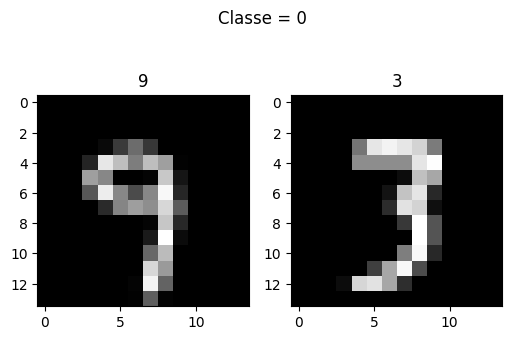

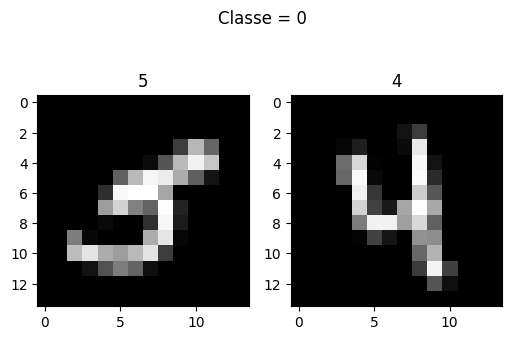

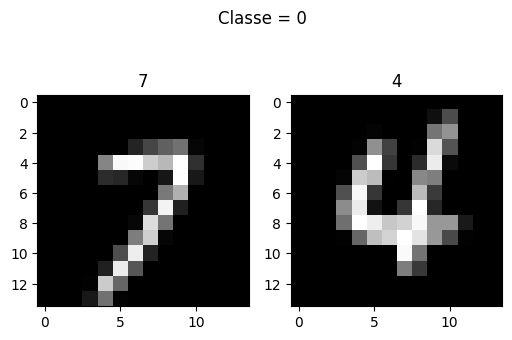

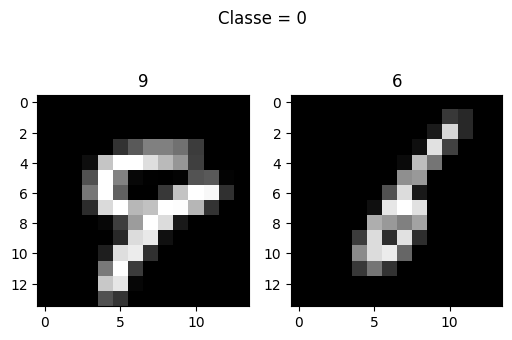

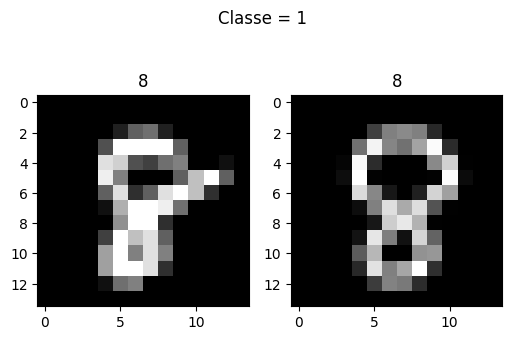

In [ ]:
# Data visualization
for index,tensor in enumerate(train_input[0:5]) :
  img1, img2 = tensor[0], tensor[1]
  fig,ax = plt.subplots(1,2)
  ax[0].imshow(img1,cmap='gray')
  ax[0].set_title(str(train_classes[index,0].item()))
  ax[1].imshow(img2,cmap='gray')
  ax[1].set_title(str(train_classes[index,1].item()))
  fig.suptitle("Classe = " + str(train_target[index].item()))
  fig.set_dpi(100)


In [ ]:
# Double checking
print("Training Set")
print(train_input.size())
print(train_target.size())
print(train_classes.size())
print("-------------------")
print("Testing Set")
print(test_input.size())
print(test_target.size())
print(test_classes.size())

Training Set
torch.Size([1000, 2, 14, 14])
torch.Size([1000])
torch.Size([1000, 2])
-------------------
Testing Set
torch.Size([1000, 2, 14, 14])
torch.Size([1000])
torch.Size([1000, 2])


## Helping functions

In [ ]:
 """
Input :-

model : Pytorch NN model
input_data : Tensor of N X 2 X 14 X 14
target_data : Tensor of N X 1
batch_size : Size of the batch

-----------------------------------

Output :-

The number of samples not well classified
"""
def compute_nb_errors(model, data_input, data_target,batch_size):

    nb_data_errors = 0

    for inputs, targets in zip(data_input.split(batch_size), data_target.split(batch_size)):
        output = model(inputs)
        _, predicted_classes = torch.max(output.narrow(1,0,2), 1)
        for k in range(len(targets)):
            if targets[k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1        
    return nb_data_errors

"""
Input :-

model : Pytorch NN model
train_input : Tensor of N x 2 x 14 x 14
train_target : Tensor of N x 1
train_classes : Tensor of N x 2

test_input : Tensor of N x 2 x 14 x 14
test_target : Tensor of N x 1
test_classes : Tensor of N x 2

epochs : the number of passes of the entire training dataset
eta : learning parameter

batch_size : Size of the batch

-----------------------------------

Output :-

The number of samples not well classified

"""
eta = 0.01
def training_model(model,
                   train_input,train_target,train_classes,
                   test_input,test_target,test_classes,
                   eta,epochs = 25,
                   batch_size = 50,
                   auxiliary_loss = True):
  
  test_acc = [0] * epochs

  # define criterion and optimizer
  # need to check the other possibilities
  criterion = nn.CrossEntropyLoss()
  aux_critierion = nn.NLLLoss()
  optimizer = optim.SGD(model.parameters(), lr = eta)


  

  for e in range(0,epochs):

    for inputs,target,classes in zip(train_input.split(batch_size),train_target.split(batch_size),train_classes.split(batch_size)):

      outputs = model(inputs)

      if auxiliary_loss : 
        prediction = outputs.narrow(1,0,2)
        aux_1 = outputs.narrow(1,2,10)
        aux_2 = outputs.narrow(1,12,10)

        loss = criterion(prediction, target) 
        loss_1 = aux_critierion(torch.sigmoid(aux_1), classes[:,0]) 
        loss_2 = aux_critierion(torch.sigmoid(aux_2), classes[:,1]) 

        loss += loss_1 + loss_2

      else : 

        loss = criterion(outputs, target)

      # optimising parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step() 

  
    train_acc = 0
    train_acc = 100 * (1 - compute_nb_errors(model, train_input, train_target,batch_size)/train_input.size(0))
    test_acc[e] = 100 * (1 - compute_nb_errors(model, test_input, test_target,batch_size)/test_input.size(0))
    # print(f"Epoch # {e+1} / Train accuracy (%): {train_acc:.2f} / Test accuracy (%): {test_acc[e]:.2f}")
     
  return test_acc

## Models

In [ ]:
# parameters
eta = 0.01

In [ ]:

# Net without Weight sharing
class Net1(nn.Module):
  def __init__(self):
    super(Net1,self).__init__()

    self.conv11 = nn.Conv2d(1,16,3)
    self.conv12 = nn.Conv2d(16,32,3)

    self.conv21 = nn.Conv2d(1,16,3)
    self.conv22 = nn.Conv2d(16,32,3)

    self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)

    self.fc1 = nn.Linear(64*4*4,64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,2)

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv11(c1))
    c1 = self.pool(c1)
    c1 = F.relu(self.conv12(c1))
    

    # Channel 2
    c2 = F.relu(self.conv21(c2))
    c2 = self.pool(c2)
    c2 = F.relu(self.conv22(c2))
    
    # Reconstruction
    output = torch.cat((c1,c2),1)
    output = output.view(-1,64*4*4)

    # Classifier
    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)

    return output

# Net with Weight sharing
class Net2(nn.Module):
  def __init__(self):
    super(Net2,self).__init__()
    
    self.conv1 = nn.Conv2d(1,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)

    self.fc1 = nn.Linear(64*4*4,64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,2)

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv1(c1))
    c1 = self.pool(c1)
    c1 = F.relu(self.conv2(c1))

    # Channel 2
    c2 = F.relu(self.conv1(c2))
    c2 = self.pool(c2)
    c2 = F.relu(self.conv2(c2))


    output = torch.cat((c1,c2),1)
    output = output.view(-1,64*4*4)
   
    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))
    output = self.fc3(output)

    return output

# Net with Auxiliary loss
class Net3(nn.Module):
  def __init__(self):
    super(Net3,self).__init__()
    
    self.conv1 = nn.Conv2d(1,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)

    self.fc1 = nn.Linear(64*4*4,64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,2)
    self.fc4 = nn.Linear(32,10)

  def forward(self,x): 
    # spliting the channels
    c1 = torch.narrow(x,1,0,1)
    c2 = torch.narrow(x,1,1,1)

    # Channel 1
    c1 = F.relu(self.conv1(c1))
    c1 = self.pool(c1)
    c1 = F.relu(self.conv2(c1))

    # Channel 2
    c2 = F.relu(self.conv1(c2))
    c2 = self.pool(c2)
    c2 = F.relu(self.conv2(c2))


    output = torch.cat((c1,c2),1)
    output = output.view(-1,64*4*4)
   
    output = F.relu(self.fc1(output))
    output = F.relu(self.fc2(output))

    prediction = self.fc3(output)  
    aux_1 = self.fc4(output)
    aux_2 = self.fc4(output)

    return torch.cat((prediction,aux_1,aux_2),1)



In [ ]:
# Net without weight sharing
model1 = Net1()
test_acc = training_model(model1,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 50,batch_size = 50,auxiliary_loss = False)
print(test_acc)

In [ ]:
# Net with weight sharing
model2 = Net2()
test_acc = training_model(model2,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 50,batch_size = 50,auxiliary_loss = False)
print(test_acc)

In [ ]:
# Net with Auxiliary loss
model3 = Net3()
test_acc = training_model(model3,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 50,batch_size = 50,auxiliary_loss = True)
print(test_acc)

## Performance evaluation

### Runs

In [ ]:
from time import perf_counter

nb_round = 30
N = 1000
epochs = 30

test_acc_1 = []
time_1 = []
test_acc_2 = []
time_2 = []
test_acc_3 = []  
time_3 = []


for i in range(nb_round):

  # Dataset
  train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(N)
  # Models
  model1 = Net1() # change here to different model
  model2 = Net2() # change here to different model
  model3 = Net3() # change here to different model

  start = perf_counter()
  test_acc_1.append(training_model(model1,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 30,batch_size = 50,auxiliary_loss=False))
  end = perf_counter()
  time_1.append(end-start)

  start = perf_counter()
  test_acc_2.append(training_model(model2,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 30,batch_size = 50,auxiliary_loss=False))
  end = perf_counter()
  time_2.append(end-start)


  start = perf_counter()
  test_acc_3.append(training_model(model3,train_input,train_target,train_classes,test_input,test_target,test_classes,eta,epochs = 30,batch_size = 50,auxiliary_loss=True))
  end = perf_counter()
  time_3.append(end-start)

  

In [ ]:
Model_1_mean = [0] * nb_round
Model_1_std = [0] * nb_round
Model_2_mean = [0] * nb_round
Model_2_std = [0] * nb_round
Model_3_mean = [0] * nb_round
Model_3_std = [0] * nb_round

for e in range(nb_round):
  Model_1_mean[e] = np.mean([row[-1] for row in test_acc_1])
  Model_1_std[e] = np.std([row[-1] for row in test_acc_1])
  Model_2_mean[e] = np.mean([row[-1] for row in test_acc_2])
  Model_2_std[e] = np.std([row[-1] for row in test_acc_2])
  Model_3_mean[e] = np.mean([row[-1] for row in test_acc_3])
  Model_3_std[e] = np.std([row[-1] for row in test_acc_3])

print(np.mean(Model_1_mean))
print(np.mean(Model_2_mean))
p rint(np.mean(Model_3_mean))
print("***")
print(np.min(Model_1_std))
print(np.max(Model_1_std))
print("***") 
print(np.min(Model_2_std))
print(np.max(Model_2_std))
print("***") 
print(np.min(Model_3_std))
print(np.max(Model_3_std))

85.76000000000006
86.6566666666667
86.36
***
1.3340664651108411
1.3340664651108411
***
0.8954266518754566
0.8954266518754566
***
1.2926974381759528
1.2926974381759528


### Plots

In [ ]:
def plot(label_1,label_2,label_3):
  Model_1_mean = [0] * epochs
  Model_1_std = [0] * epochs
  Model_2_mean = [0] * epochs
  Model_2_std = [0] * epochs
  Model_3_mean = [0] * epochs
  Model_3_std = [0] * epochs

  for e in range(epochs):
    Model_1_mean[e] = np.mean([row[e] for row in test_acc_1])
    Model_1_std[e] = np.std([row[e] for row in test_acc_1])
    Model_2_mean[e] = np.mean([row[e] for row in test_acc_2])
    Model_2_std[e] = np.std([row[e] for row in test_acc_2])
    Model_3_mean[e] = np.mean([row[e] for row in test_acc_3])
    Model_3_std[e] = np.std([row[e] for row in test_acc_3])

  epochs_x = list(range(1,epochs+1))
  fig, ax = plt.subplots()
  plt.grid()

  ax.plot(epochs_x,Model_1_mean, color='r', label=label_1)
  ax.fill_between(epochs_x, ([x1 - x2 for (x1, x2) in zip(Model_1_mean, Model_1_std)]),
                  ([x1 + x2 for (x1, x2) in zip(Model_1_mean, Model_1_std)]), color='r', alpha=0.1)

  ax.plot(epochs_x,Model_2_mean, color='b', label=label_2)
  ax.fill_between(epochs_x, ([x1 - x2 for (x1, x2) in zip(Model_2_mean, Model_2_std)]),
                  ([x1 + x2 for (x1, x2) in zip(Model_2_mean, Model_2_std)]), color='b', alpha=0.1)
  

  ax.plot(epochs_x,Model_3_mean, color='g', label=label_3)
  ax.fill_between(epochs_x, ([x1 - x2 for (x1, x2) in zip(Model_3_mean, Model_3_std)]),
                  ([x1 + x2 for (x1, x2) in zip(Model_3_mean, Model_3_std)]), color='g', alpha=0.1)

  plt.legend()
  fig.set_size_inches(12, 8)
  fig.set_dpi(150) 
  plt.xlabel('Epoch', fontsize=10)
  plt.ylabel('Test Accuracy in [%]', fontsize=10)
  plt.savefig('model.png')
  plt.show()

### Final Run

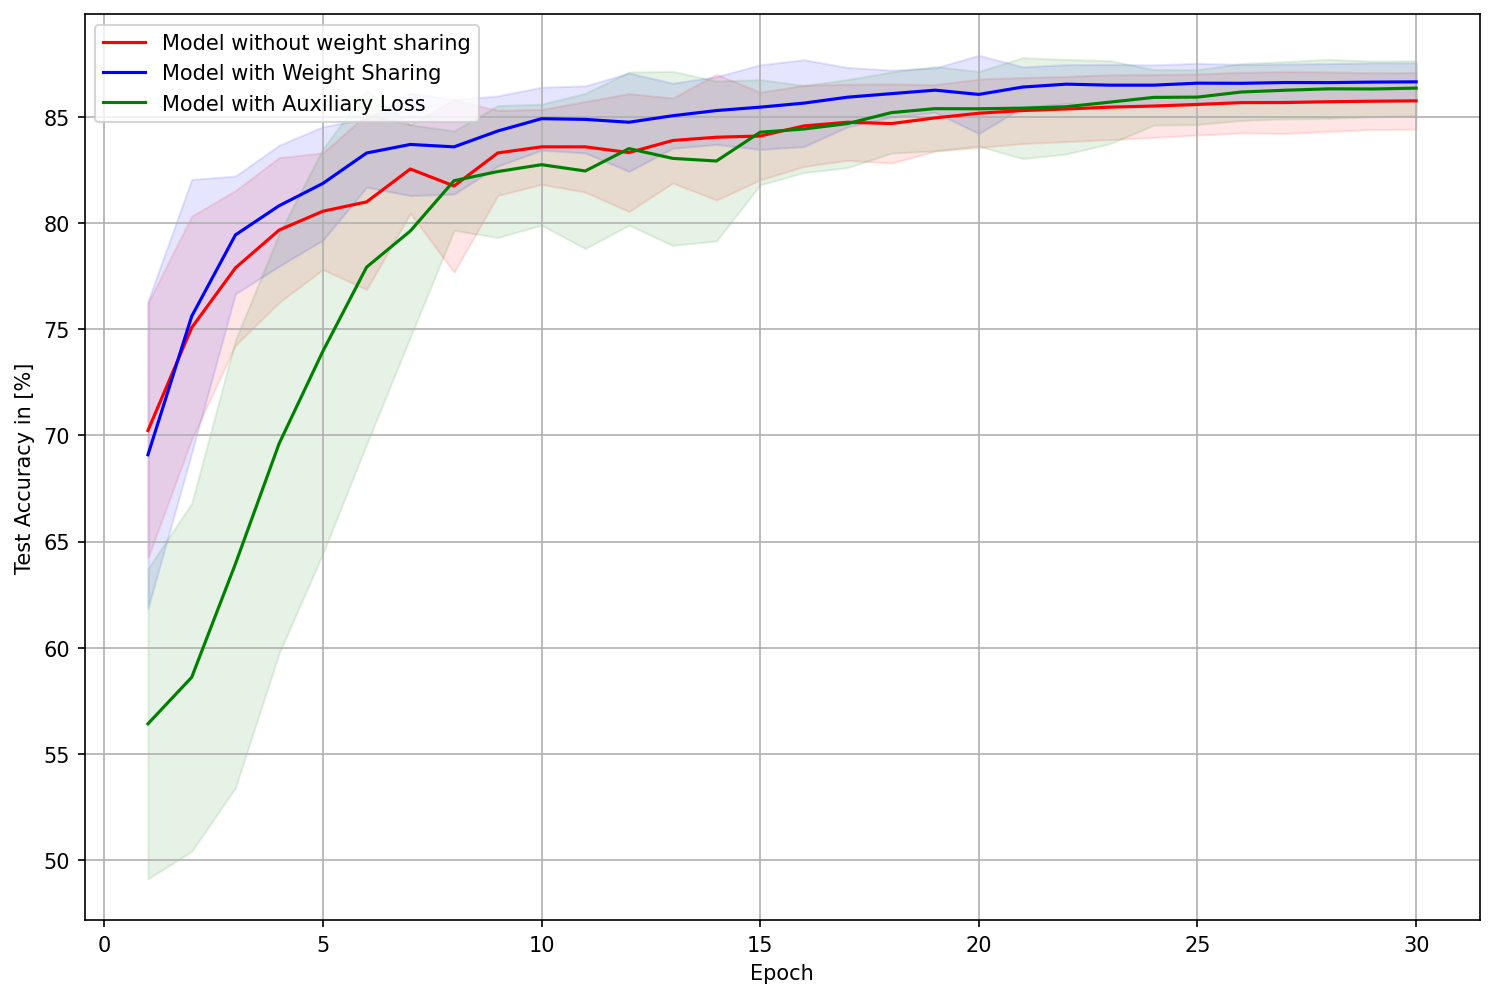

In [ ]:
plot('Model without weight sharing','Model with Weight Sharing','Model with Auxiliary Loss')

In [ ]:
print(np.mean(time_1),np.std(time_1))
print(np.mean(time_2),np.std(time_2))

9.834579888933318 0.15084896832749994
9.74201760203332 0.11770158563856425
